Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Oleg Bushtyrkov | k12338089 | 03.06.2024, 10:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 5 &ndash; Drug Discovery (Assignment)</h2>

<b>Authors:</b> S. Luukkonen (adapted from B. Schäfl, S. Lehner, J. Schimunek, J. Brandstetter, E. Kobler)<br>
<b>Date:</b> 18-04-2023

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u5_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u5_utils.py</code> need to be installed.

In [433]:
!pip install rdkit

import warnings
warnings.filterwarnings(action=r'ignore', category=UserWarning)

# Import pre-defined utilities specific to this notebook.
import u5_utils as u5

# Import additional utilities needed in this notebook.
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator 

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u5.setup_jupyter()

# Check minimum versions.
u5.check_module_versions()

%reload_ext autoreload
%autoreload 2

Defaulting to user installation because normal site-packages is not writeable
Installed Python version: 3.10 (✓)
Installed numpy version: 1.26.4 (✓)
Installed pandas version: 2.2.1 (✓)
Installed scikit-learn version: 1.3.1 (✓)
Installed matplotlib version: 3.8.3 (✓)
Installed seaborn version: 0.13.0 (✓)
Installed PIL version: 9.0.1 (✓)
Installed rdkit version: 2023.09.6 (✓)


<h2>Loading molecules and extracting information</h2>
The first step of working with molecule data is actually getting them into memory as <tt>RDKit</tt> molecule objects.

<div class="alert alert-warning">
    <b>Exercise 1.1. [3 Points]</b>
    <ul>
        <li>Load the <i>molecule</i> data set <tt>molecules_logP.csv</tt> using the <code>u5.load_molecules_from_csv</code>.</li>
        <li>Print out the number of molecules.</li>
        <li>Visualize the first molecule with its properties.</li>
    </ul>
</div>

7995 molecules in dataset


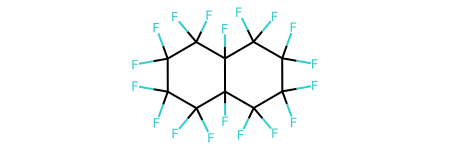

In [434]:
# your code/answer goes here
molecule_data = u5.load_molecules_from_csv("resources/molecules_logP.csv")
print(f"{len(molecule_data)} molecules in dataset")
mole_0 = molecule_data[0]
mole_0

<div class="alert alert-warning">
    <b>Exercise 1.2. [5 Points]</b>
    <ul>
        <li> MW stands for the molecular weight of the molecule. What does the acronym <i>logP</i> stand for? Which property do the extracted molecules share? Cite your sources (find an appropriate source, even if you know it by heart).</li>
    </ul>
</div>

'logP' is the 'octanol-water' Partition Coefficient, the measure of how hydrophobic/hydrophilic a molecule is.  
https://www.biotage.com/blog/what-is-the-role-of-logp-in-sample-prep-methods  
https://www.acdlabs.com/wp-content/uploads/download/app/physchem/making_sense.pdf

<div class="alert alert-warning">
    <b>Exercise 1.3. [2 Points]</b>
    <ul>
        <li> Visualize the distribution of the <i>logP</i> values </li>
    </ul>
</div>

<Axes: ylabel='Count'>

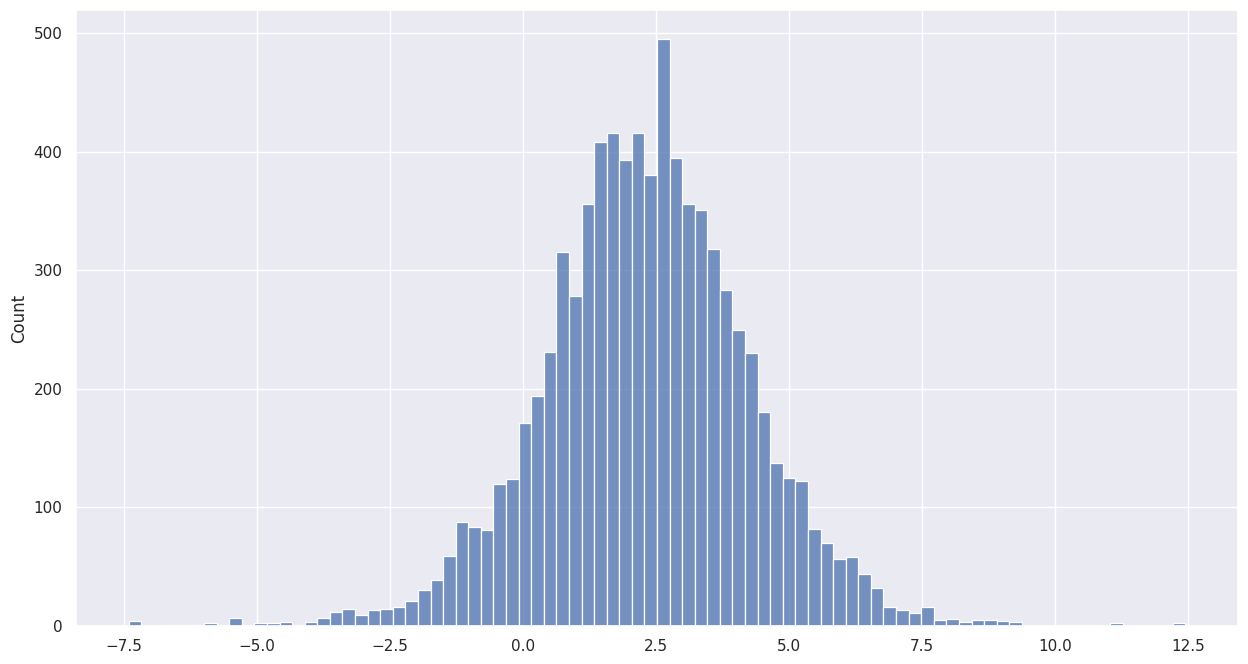

In [435]:
# your code/answer goes here
import matplotlib.pyplot as plt
logP_vals = [float(molecule.GetProp('logP')) for molecule in molecule_data]
plt.figure(figsize=(15,8))
sns.histplot(logP_vals)

<div class="alert alert-warning">
    <b>Exercise 1.4. [5 Points]</b>
    <ul>
        <li>Make a selection of molecules by sorting them by their <i>logP</i> values and pick every 1000th molecules.
        <li>Visualize the selected molecules in a <i>$2times 4$ grid</i> including their <i>Formula</i> as well as their <i>logP</i> values.</li>
    </ul>
</div>

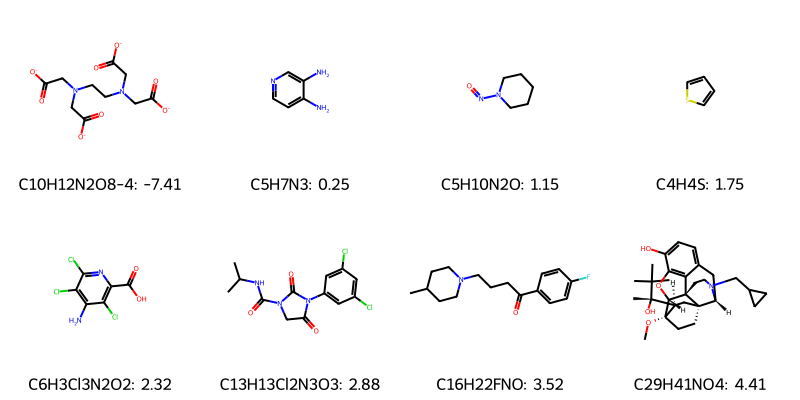

In [436]:
# your code/answer goes here
# sort logP_vals numerically, then reverse engineer the molecules and get each 1000th (k*1000)
negatives = sorted(list(filter(lambda x: '-' in x.GetProp('logP'), molecule_data)), key=lambda x: x.GetProp('logP'), reverse=True)
positives = sorted(list(filter(lambda x: '-' not in x.GetProp('logP'), molecule_data)), key=lambda x: x.GetProp('logP'))
sorted_mols = negatives + positives
selected_mols = []
selected_mol_logP = []
selected_mol_Formula = []
for i in range(0, (len(sorted_mols)//1000)+1):
    selected_mols.append(sorted_mols[i*1000])
    selected_mol_logP.append(sorted_mols[i*1000].GetProp('logP'))
    selected_mol_Formula.append(sorted_mols[i*1000].GetProp('Formula'))
legend = []
for i in range(len(selected_mols)):
    legend.append(f"{selected_mol_Formula[i]}: {selected_mol_logP[i]}")
Chem.Draw.MolsToGridImage(selected_mols, molsPerRow=4, legends=legend)

<div class="alert alert-warning">
    <b>Exercise 1.5. [2 Points]</b>
    <ul>
        <li>Do you observe <i>visually similar</i> molecules? Comment on this.</li>
    </ul>
</div>
        


Each Molecule has at least one (1) ring in it's structure, comprised of single bonds, double bonds, or a mixture of both.

<div class="alert alert-warning">
    <b>Exercise 1.6. [3 Points]</b>
    <ul>
        <li>For each of the previously found molecules, <i>annote</i> each atom by its atom index and compute each molecule's <i>atom count</i>.</li>
        <li>Visualize the result in a <i> $2\times 4$ grid</i> including their <i>Formulas</i> as well as their <i>atom counts</i> (sorted in ascending order according to <i>atom count</i>).</li>
    </ul>
</div>

In [437]:
def annotate_molecule_atoms(molecule: Chem.rdchem.Mol) -> Chem.rdchem.Mol:
    """
    Annotate molecule atoms with corresponding atom numbers.
    
    :param molecule: molecule to annotate
    :return: annotated molecule
    """
    molecule_annotated = deepcopy(molecule)
    for atom in molecule_annotated.GetAtoms():
        atom.SetProp('atomNote', str(atom.GetIdx()))
    return molecule_annotated

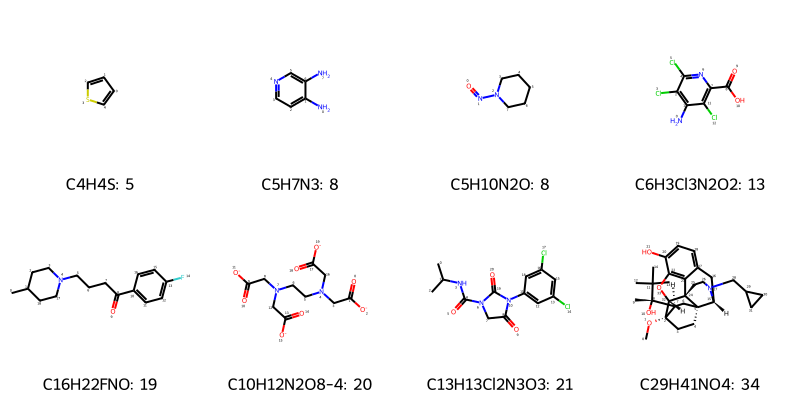

In [438]:
# your code/answer goes here
annotated_mols = sorted([annotate_molecule_atoms(i) for i in selected_mols], key=lambda x: len(x.GetAtoms()))
legend = [f"{x.GetProp('Formula')}: {len(x.GetAtoms())}" for x in annotated_mols]
Chem.Draw.MolsToGridImage(annotated_mols, molsPerRow=4, legends=legend)

Looks like I did what I had to!! ^_^

<h2>Atomic Properties and Bonds</h2>
<p>Extracting <i>atomic</i> as well as <i>bond</i> properties often allows for a more thorough undertstanding of the molecules at hand. Unsurprisingly, <tt>RDKit</tt> provides the necessary functionality for this purpose – almost. The missing functionality may be taken from the exercise notebook, but needs to be adapted accordingly.</p>

<div class="alert alert-warning">
    <b>Exercise 2.1. [10 Points]</b>
    <ul>
        <li>Compute the <i>amount of atoms</i> participating in a <i>ring structure</i> for each of the molecules of the previous exercise.</li>
        <li>Adapt and apply <code>annotate_molecule_atoms</code> in a way to annotate an atom with an <tt>R</tt> if it is <i>participating</i> in a ring structure.</li>
        <li>Visualize the result in a <i> $2\times 4$ grid</i> including their <i>Formulas</i> as well as their <i>amount of ring atoms</i> (sorted in descending order according to the latter).</li>
    </ul>
</div>

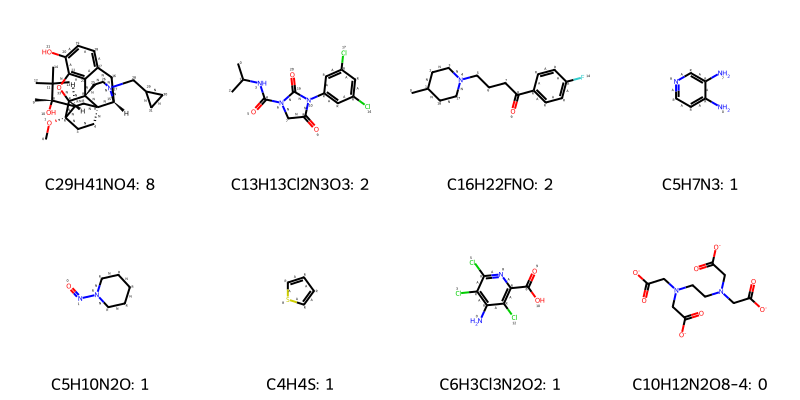

In [442]:
# your code/answer goes here
def annotate_molecule_atoms(molecule: Chem.rdchem.Mol) -> Chem.rdchem.Mol:
    """
    Annotate molecule atoms with corresponding atom numbers.
    
    :param molecule: molecule to annotate
    :return: annotated molecule
    """
    rings = molecule.GetRingInfo().AtomRings()
    molecule_annotated = deepcopy(molecule)
    for atom in molecule_annotated.GetAtoms():
        for ring in rings:
            if int(atom.GetIdx()) in ring:
                atom.SetProp('atomNote', 'R')
            else:
                atom.SetProp('atomNote', str(atom.GetIdx()))
    return molecule_annotated

annotated_mols = sorted([annotate_molecule_atoms(i) for i in selected_mols], key=lambda x: len(x.GetRingInfo().AtomRings()), reverse = True)
legend = [f"{x.GetProp('Formula')}: {len(x.GetRingInfo().AtomRings())}" for x in annotated_mols]
Chem.Draw.MolsToGridImage(annotated_mols, molsPerRow=4, legends=legend)

<div class="alert alert-warning">
    <b>Exercise 2.2. [10 Points]</b>
    <ul>
        <li>Compute the <i>amount of aromatic bonds</i> for each of the molecules of the previous exercise.</li>
        <li>Adapt and apply <code>annotate_molecule_atoms</code> in a way to mark bonds with the <i>first letter</i> of their respective <i>type</i>.</li>
        <li>Visualize the result in a <i> $2\times 4$ grid</i> including their <i>Formulas</i> as well as their <i>amount of aromatic bonds</i> (sorted in descending order according to the latter).</li>
    </ul>

Hint: You can use `GetIsAromatic` to check if a bond is <a href="https://en.wikipedia.org/wiki/Aromaticity">Aromatic</a>.
</div>


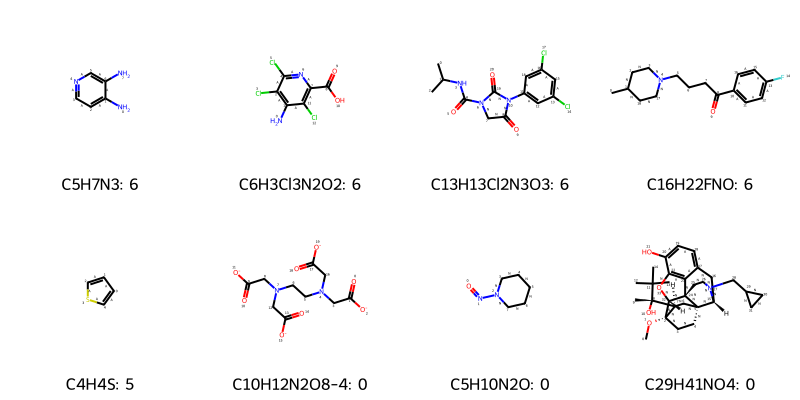

In [451]:
# your code/answer goes here
num_aromatic_bonds = []
def isRingAromatic(mol, bondRing):
        bond_count = 0
        for id in bondRing:
            if mol.GetBondWithIdx(id).GetIsAromatic():
                mol.GetBonds()[id].SetProp('bondNote', 'A')
                bond_count += 1
            else:
                mol.GetBonds()[id].SetProp('bondNote', 'N')
        mol.SetProp('aromBonds', f'{bond_count}')

def annotate_molecule_atoms(molecule: Chem.rdchem.Mol) -> Chem.rdchem.Mol:
    """
    Annotate molecule atoms with corresponding atom numbers.
    
    :param molecule: molecule to annotate
    :return: annotated molecule
    """
    molecule_annotated = deepcopy(molecule)
    for atom in molecule_annotated.GetAtoms():
        atom.SetProp('atomNote', str(atom.GetIdx()))
    rings = molecule.GetRingInfo().BondRings()
    for bond in rings:
        isRingAromatic(molecule, bond)
    return molecule_annotated

annotated_mols = sorted([annotate_molecule_atoms(i) for i in selected_mols], key=lambda x: x.GetProp('aromBonds'), reverse = True)
legend = [f"{x.GetProp('Formula')}: {x.GetProp('aromBonds')}" for x in annotated_mols]
Chem.Draw.MolsToGridImage(annotated_mols, molsPerRow=4, legends=legend)

<h2>Vizualizing and analyzing the molecular dataset</h2>
<p>In the following exercises, you'll have to dig into analyzing the full dataset.</p>

<div class="alert alert-warning">
    <b>Exercise 3.1. [3 Points]</b>
    <ul>
        <li>Compute Morgan fingerprints with <i>radius</i> of 2 and <i>fingerprint size</i> of 1024 and save them into a pd.DataFrame().</li>
    </ul>
</div>

In [452]:
# your code/answer goes here
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
fps = np.array([mfpgen.GetFingerprint(mol) for mol in molecule_data])
molecule_data_ecfp = pd.DataFrame(fps)
molecule_data_ecfp

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class="alert alert-warning">
    <b>Exercise 3.2. [3 Points]</b>
    <ul>
        <li>Plot the fraction of presence of a feature in the molecules of the dataset for each feature.</li>
        <li>Print out the average fraction.</li> 
    </ul>
</div>

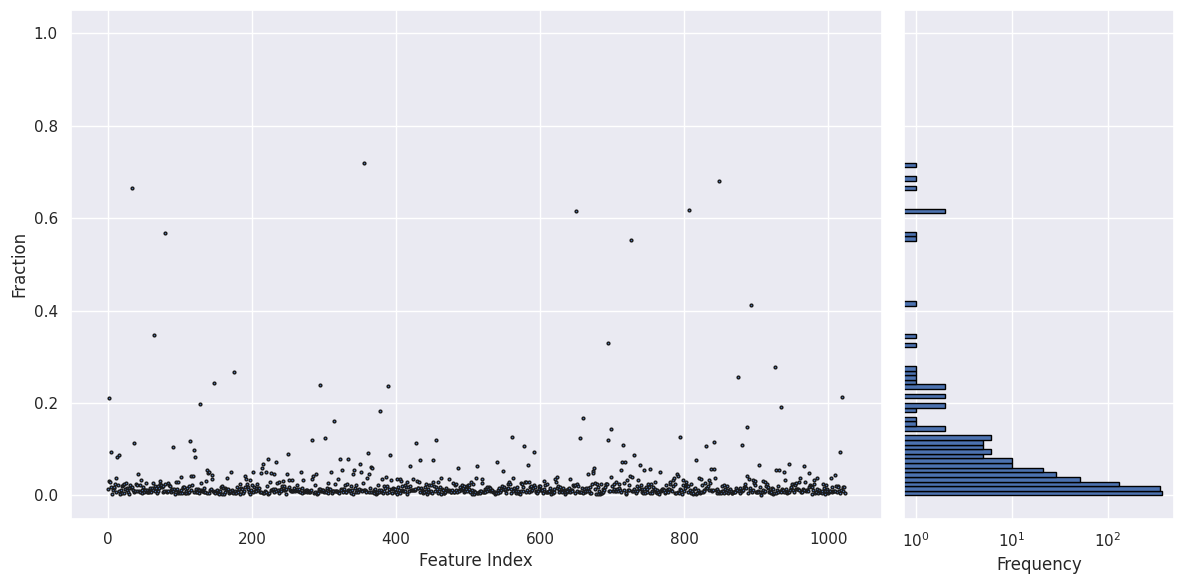

Average fraction of feature presence: 0.03


In [453]:
# your code/answer goes here
u5.plot_feature_fractions(molecule_data_ecfp)
print(f'Average fraction of feature presence: {molecule_data_ecfp.mean().mean():.2f}')

<div class="alert alert-warning">
    <b>Exercise 3.3. [3 Points]</b>
    <ul>
        <li>Comment on the presence of the features/subsructures in the dataset and its diversity.</li>
    </ul>
</div>

Similar to the Lecture Notebook, the low feature presence indicates high diversity in the dataset, as only a few molecules possess most of the substructures.

<div class="alert alert-warning">
    <b>Exercise 3.4. [5 Points]</b>
    <ul>
        <li>First, reduce the dimensionality of the molecule dataset using <i>PCA</i> to a 32 features, then reduce this 32 features into 2 with <i>t-SNE</i> (use perplexity 10 and seed of 42).</li>
        <li>Bin the logP values into 5 bins.</li>
        <li>Visualize the 2D downprojection with the binned logP values as labels.
    </ul>
</div>

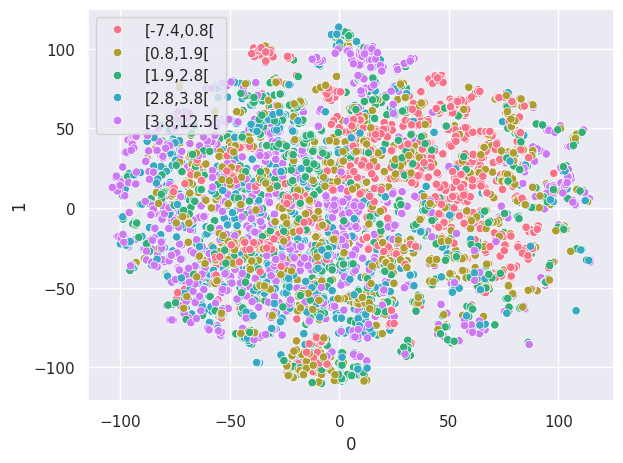

In [454]:
# your code/answer goes here
np.random.seed(seed=42)
molecule_data_ecfp_pca = u5.apply_pca(n_components=32, data=molecule_data_ecfp)
molecule_data_ecfp_tsne = u5.apply_tsne(n_components=2, data=molecule_data_ecfp_pca, perplexity=10.0)
logPs = [float(mol.GetProp('logP')) for mol in molecule_data]
binned_logPs = u5.bin_contineous_label_values(logPs, num_bins=5)
u5.plot_points_2d(molecule_data_ecfp_tsne, targets=binned_logPs)

<div class="alert alert-warning">
    <b>Exercise 3.5. [3 Points]</b>
    <ul>
        <li>Are there any visible clusters? In the structure of the downprojection or the binned logP labels?
    </ul>
</div>

There is a medium cluster above the '0' point of the down-projection's x-axis, as well as a few smaller clusters at the top ((0,100) , (-50,100))  
Other than that, most of the data is gathered in a big cluster in the middle.  
Although there are label clusters at (50,10)[red], (0,0)[purple], (10,95)[purple]

<div class="alert alert-warning">
    <b>Exercise 3.6. [3 Points]</b>
    <ul>
        <li>Cluster the dataset with <i>Sphere exclusion clustering</i> with threshold of 0.96 on the raw fingerprints.</li>
        <li>Print the number of clusters.</li>
        <li>Visualize the TSNE downproject with the cluster indices as labels. Turn of the legend.</li>
    </ul>
</div>

Number of clusters: 9


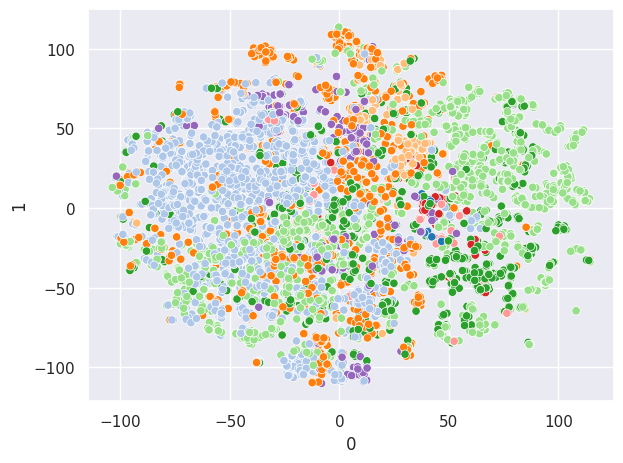

In [455]:
# your code/answer goes here
np.random.seed(seed=42)
clusters = u5.apply_sphere_exclusion_clustering(data=molecule_data_ecfp, th=0.96)
print('Number of clusters:', len(set(clusters)))
u5.plot_points_2d(molecule_data_ecfp_tsne, targets=clusters, legend=False, multi_color_palette='tab20')

<div class="alert alert-warning">
    <b>Exercise 3.7. [3 Points]</b>
    <ul>
        <li>Comment on the separability of the molecule clusters with respect to the downprojection.</li>
    </ul>
</div>

While some of the molecule clusters sit distinctly from the majority (light-blue and light-green), the rest are rather mixed together, demonstrating low separability and indicating loss of information due to dimensionality reduction from both PCA and t-SNE.

<div class="alert alert-warning">
    <b>Exercise 3.8. [5 Points]</b>
    <ul>
        <li>Compute the sizes of the clusters and print out the size of the smallest, median and largest clusters.</li>
    </ul>
    Hint: the <code>Counter</code> from the <code>collections</code> package might be useful.
</div>

In [456]:
# your code/answer goes here
from collections import Counter
sorted_clusters = sorted(list(Counter(clusters).items()), key=lambda x: x[-1], reverse=True)
print(f"Largest Cluster Size: {sorted_clusters[0][-1]} \nMedian Cluster Size: {sorted_clusters[(len(sorted_clusters)//2)][-1]} \nSmallest Cluster Size: {sorted_clusters[-1][-1]}")

Largest Cluster Size: 2567 
Median Cluster Size: 464 
Smallest Cluster Size: 28


<div class="alert alert-warning">
    <b>Exercise 3.9. [3 Points]</b>
    <ul>
        <li>Plot <i>the first 30</i> molecules of the <i>median cluster</i> in a grid with their <i>Formula</i>.</li>
    </ul>
</div>

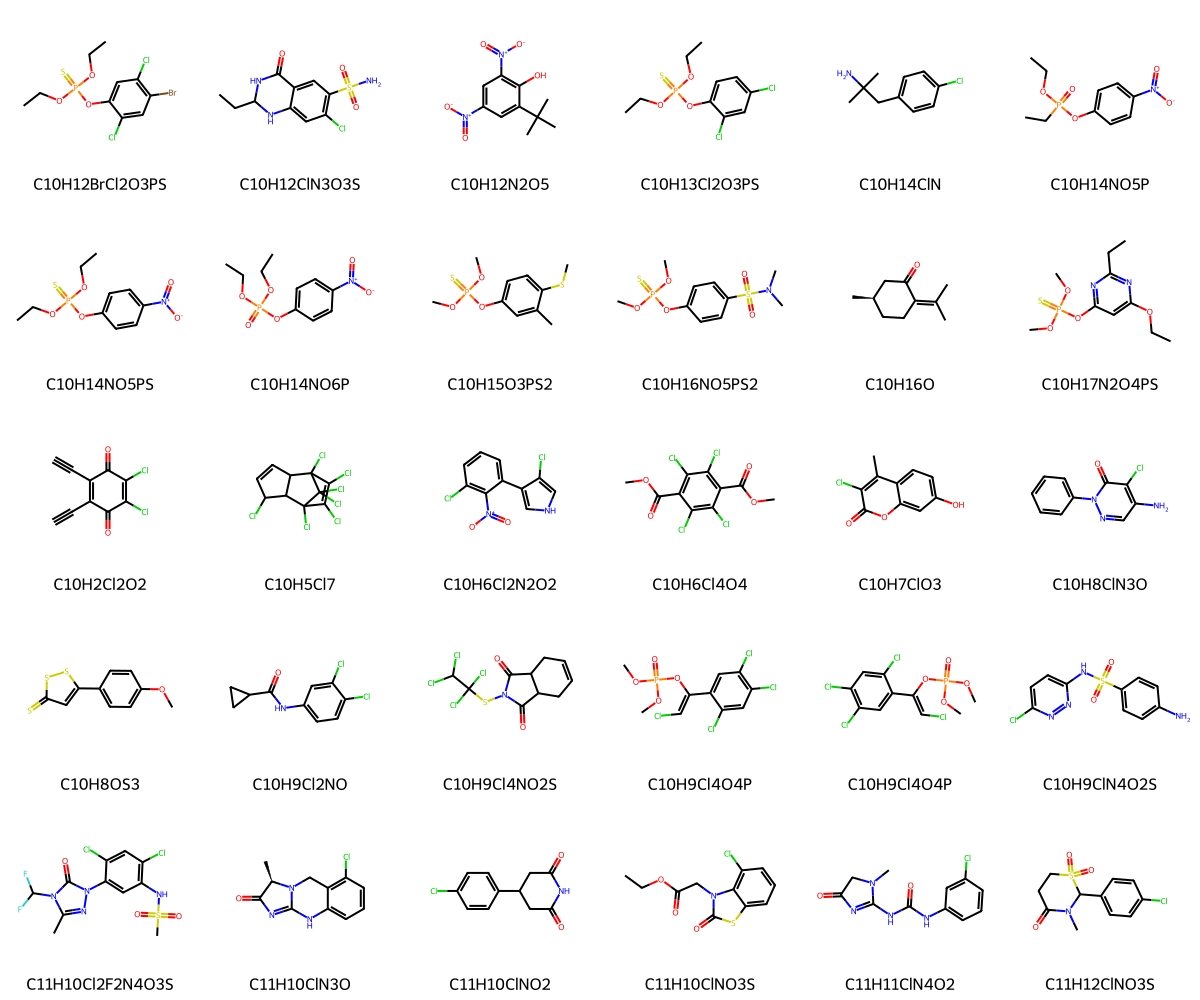

In [457]:
# your code/answer goes here
cluster_indices = [i for i, cluster_id in enumerate(clusters) if cluster_id == 8]
cluster_molecules = [molecule_data[i] for i in cluster_indices]
cluster_molecule_labels = [f'{mol.GetProp("Formula")}' for mol in cluster_molecules]

Chem.Draw.MolsToGridImage(
    cluster_molecules,
    legends=cluster_molecule_labels,
    maxMols=30,
    molsPerRow=6
)

<div class="alert alert-warning">
    <b>Exercise 3.10. [3 Points]</b>
    <ul>
        <li>Comment the structures of the molecules in the median cluster. Do you see any common chemical substructures in the cluster. If yes what? Do you see any outlier?
    </ul>
</div>

Every molecule has at least one ring in it's structure, and at least a Chlorine tail or an Oxygen tail. Nitrogen is also present in most molecules.

<h2>Quantitative structure-<i>property</i> relationship modeling</h2>
<p>In the following exercises, you'll have to build QSPR models to predict the logP value of the molecules.</p>

<div class="alert alert-warning">
    <b>Exercise 4.1. [5 Points]</b>
    <ul>
        <li>Create a dataframe containing the Morgan fingerprints, the logP value and the cluster id for each molecule of dataset.</li>
        <li>Divide the dataset into a training and test set with the <i>cluster split</i> with a test set fraction of approximately 20%.</li>
        <li>Print the training and test set sizes.</li>
        <li>Visualize the data split in the downprojection.</li>
    </ul>
</div>

Train set size:	 7053	 (0.88)
Test set size:	 942	 (0.12)


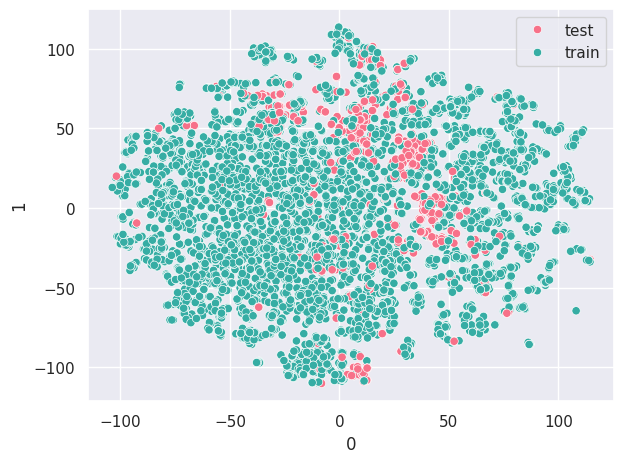

In [458]:
# your code/answer goes here
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
fps = np.array([mfpgen.GetFingerprint(mol) for mol in molecule_data])
molecule_dataset = pd.DataFrame(fps)
molecule_dataset['logP'] = logPs
molecule_dataset['Cluster'] = [cluster_id for i, cluster_id in enumerate(clusters)]

data_train, data_test = u5.apply_cluster_split(molecule_dataset, test_size=0.20)
print(f'Train set size:\t {data_train.shape[0]}\t ({data_train.shape[0]/(molecule_dataset.shape[0]):.2f})')
print(f'Test set size:\t {data_test.shape[0]}\t ({data_test.shape[0]/(molecule_dataset.shape[0]):.2f})')

labels = ['train' if i in data_train.index else 'test' for i in molecule_dataset.index]
u5.plot_points_2d(molecule_data_ecfp_tsne.loc[molecule_dataset.index], targets=labels)

<div class="alert alert-warning">
    <b>Exercise 4.2. [5 Points]</b>
    <ul>
        <li>With the help of <code>u5.train_and_evalute_sklearn_regressor</code> train and evaluate a <tt>sklearn</tt>'s <a hhref="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor"><code>RandomForestRegressor</code></a> with <i>default parameters</i>.
        <li>Comment on the performace of the model.</li>
    </ul>
</div>

Train mean_squared_error: 0.177
Test mean_squared_error: 1.562


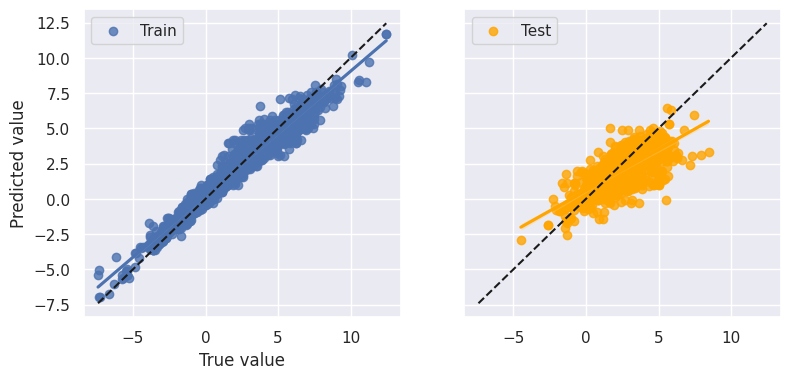

In [459]:
# your code/answer goes here
from sklearn.ensemble import RandomForestRegressor
_ = u5.train_and_evaluate_sklearn_regressor(
    model = RandomForestRegressor(),
    X_train=data_train.drop(['logP', 'Cluster'], axis=1).values,
    y_train=data_train['logP'].values,
    X_test=data_test.drop(['logP', 'Cluster'], axis=1).values,
    y_test=data_test['logP'].values,
)

Training Performance was very good with a low loss.  
Test Performance was alright. The loss is quite low, but there is noticeable deviation from the line-of-best-fit.

<div class="alert alert-warning">
    <b>Exercise 4.3. [15 Points]</b>
    <ul>
        <li>Create a model and train is so that you have a test set mean squarred error below 1.3.</li>
        <li>Keep the same train-test split for a fair comparison, but outside of that you can do want ever you want (i.e. change the features, model type, hyperparameters...).</li>
    </ul>
    Hints:
    <ul>
        <li>Take a look at the different ML models implemented in <tt>sklearn</tt> <a href="https://scikit-learn.org/stable/supervised_learning.html">here</a>.</li>
        <li>You can also use a non-<tt>sklearn</tt> model (<i>e.g.</i>, <tt>Pytorch</tt>) in which case evaluate your test set performance with <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error"><code>mean_squared_error</code></a> from <tt>sklearn</tt>.</li>
    </ul>    
</div>

Train mean_squared_error: 0.760
Test mean_squared_error: 1.441


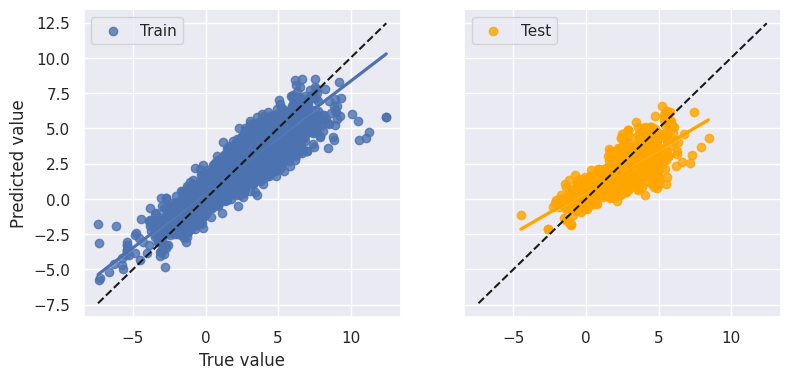

In [510]:
# your code/answer goes here
import sklearn as sk
## model = SVR(C=-1, gamma='scale', kernel='rbf', epsilon=0.1)
## MLP
_ = u5.train_and_evaluate_sklearn_regressor(
    model = sk.linear_model.SGDRegressor(max_iter=2000, l1_ratio=0.1),
    X_train=data_train.drop(['logP', 'Cluster'], axis=1).values,
    y_train=data_train['logP'].values,
    X_test=data_test.drop(['logP', 'Cluster'], axis=1).values,
    y_test=data_test['logP'].values
)